# Lucene with Modified Queries

**Purpose**: This document serves to understand how our Precision / Recall on Lucene queries would change as a result of query preprocessing.

## Loading our Dataset

In [1]:
import utils
import pickle
import pandas as pd
from tqdm import tqdm_notebook
from joblib import Parallel, delayed
from multiprocessing import cpu_count
import numpy as np
import seaborn as sns

In [2]:
claims, labels, article_list, claim_set, claim_to_article = utils.extract_fever_jsonl_data("../train.jsonl")

Num Distinct Claims 109810
Num Data Points 125051


## Developing a query preprocessor.

In [3]:
import nltk

In [4]:
tokens = nltk.word_tokenize(claims[2])

*Potthast et al* used nouns, verbs, and adjectives only in their queries.

In [5]:
nltk.help.upenn_tagset()


$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

In [79]:
#desired_pos = ["JJ", "JJR", "JJS", "NN", "NN", "NNP", "NNPS", "NNS", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]
#desired_pos = ["CD", "FW", "JJ", "JJR", "JJS", "NN", "NN", "NNP", "NNPS", "NNS"]
desired_pos = ["NN", "NN", "NNP", "NNPS", "NNS", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]

In [80]:
def preprocess_query(q, desired_pos):
    tokens = nltk.word_tokenize(q)
    pos = nltk.pos_tag(tokens)
    final_res = []
    for p in pos:
        if p[1] in desired_pos:
            final_res.append(p[0])
            
    return " ".join(final_res)

In [81]:
preprocess_query(claims[3], desired_pos)

'History art includes architecture dance sculpture music painting poetry literature theatre film photography arts'

## Running Precision, Recall

In [82]:
k = [1, 2, 5, 10, 20, 50, 100, 200, 300, 400]

In [83]:
def score_claim(claim):
    cleaned_claim = preprocess_query(claim, desired_pos)
    cleaned_claim = cleaned_claim.replace("/", " ")
    choices = utils.query_lucene(cleaned_claim, str(max(k)))
    retrieved = utils.process_lucene_output(choices)

    if len(retrieved)==0:
        mAP = {}
        for i in k:
            mAP[i] = {}
            mAP[i]['precision'] = 0.0
            mAP[i]['recall'] = 0.0
        return mAP
    
    relevant = claim_to_article[claim]
    mAP = {}
    for i in k:
        precision = utils.calculate_precision(retrieved=retrieved, relevant=relevant, k=i)
        recall = utils.calculate_recall(retrieved=retrieved, relevant=relevant, k=i)
        mAP[i] = {}
        mAP[i]['precision'] = precision
        mAP[i]['recall'] = recall
    return mAP

In [84]:
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed

def parallel_process(array, function, n_jobs=16, use_kwargs=False, front_num=3):
    """
        A parallel version of the map function with a progress bar. 

        Args:
            array (array-like): An array to iterate over.
            function (function): A python function to apply to the elements of array
            n_jobs (int, default=16): The number of cores to use
            use_kwargs (boolean, default=False): Whether to consider the elements of array as dictionaries of 
                keyword arguments to function 
            front_num (int, default=3): The number of iterations to run serially before kicking off the parallel job. 
                Useful for catching bugs
        Returns:
            [function(array[0]), function(array[1]), ...]
    """
    #We run the first few iterations serially to catch bugs
    if front_num > 0:
        front = [function(**a) if use_kwargs else function(a) for a in array[:front_num]]
    #If we set n_jobs to 1, just run a list comprehension. This is useful for benchmarking and debugging.
    if n_jobs==1:
        return front + [function(**a) if use_kwargs else function(a) for a in tqdm_notebook(array[front_num:])]
    #Assemble the workers
    with ProcessPoolExecutor(max_workers=n_jobs) as pool:
        #Pass the elements of array into function
        if use_kwargs:
            futures = [pool.submit(function, **a) for a in array[front_num:]]
        else:
            futures = [pool.submit(function, a) for a in array[front_num:]]
        kwargs = {
            'total': len(futures),
            'unit': 'it',
            'unit_scale': True,
            'leave': True
        }
        #Print out the progress as tasks complete
        for f in tqdm_notebook(as_completed(futures), **kwargs):
            pass
    out = []
    #Get the results from the futures. 
    for i, future in tqdm_notebook(enumerate(futures)):
        try:
            out.append(future.result())
        except Exception as e:
            out.append(e)
    return front + out

In [85]:
result = parallel_process(list(claim_to_article.keys())[:10000], score_claim, n_jobs=6)

In [ ]:
from multiprocessing.dummy import Pool as ThreadPool 
pool = ThreadPool(8)
results = pool.map(score_claim, list(claim_to_article.keys())[:10000])

In [ ]:
for c in tqdm_notebook(list(claim_to_article.keys())[:10000]):
    score_claim(c)

In [ ]:
%load_ext line_profiler

In [ ]:
%lprun -f preprocess_query score_claim(claims[0])

In [ ]:
loadCached = False

In [ ]:
if not loadCached:
    result = Parallel(n_jobs=8, verbose=1)(delayed(score_claim)(c) for c in list(claim_to_article.keys())[:10000])
    with open("result_pos_two.pkl", "wb") as f:
        pickle.dump(result, f)
else:
    with open("result_pos_two.pkl", "rb") as f:
        result = pickle.load(f)

In [25]:
result

[{1: {'precision': 0.0, 'recall': 0.0},
  2: {'precision': 0.0, 'recall': 0.0},
  5: {'precision': 0.0, 'recall': 0.0},
  10: {'precision': 0.0, 'recall': 0.0},
  20: {'precision': 0.0, 'recall': 0.0},
  50: {'precision': 0.0, 'recall': 0.0},
  100: {'precision': 0.0, 'recall': 0.0},
  200: {'precision': 0.0, 'recall': 0.0},
  300: {'precision': 0.0, 'recall': 0.0},
  400: {'precision': 0.0, 'recall': 0.0}},
 {1: {'precision': 0.0, 'recall': 0.0},
  2: {'precision': 0.0, 'recall': 0.0},
  5: {'precision': 0.0, 'recall': 0.0},
  10: {'precision': 0.0, 'recall': 0.0},
  20: {'precision': 0.0, 'recall': 0.0},
  50: {'precision': 0.0, 'recall': 0.0},
  100: {'precision': 0.0, 'recall': 0.0},
  200: {'precision': 0.0, 'recall': 0.0},
  300: {'precision': 0.0, 'recall': 0.0},
  400: {'precision': 0.0, 'recall': 0.0}},
 {1: {'precision': 0.0, 'recall': 0.0},
  2: {'precision': 0.0, 'recall': 0.0},
  5: {'precision': 0.0, 'recall': 0.0},
  10: {'precision': 0.0, 'recall': 0.0},
  20: {'precisi

In [66]:
def calculatemAP(mAP, k):
    mAP_final = {}
    
    for i in k:
        mAP_final[i] = {}
        mAP_final[i]['precision'] = []
        mAP_final[i]['recall'] = []
        
    for ap in mAP:
        if len(ap)!=0:
            for k, v in ap.items():
                mAP_final[k]['precision'].append(v['precision'])
                mAP_final[k]['recall'].append(v['recall'])
    
    return mAP_final

def displaymAP(mAP):
    for k in sorted(mAP.keys()):
        for k_i, v_i in mAP[k].items():
            print("{} @ {}: {}".format(k_i, k, np.mean(v_i)))
        print()
            
def calculate_precision_recall(mAP):
    precision = np.zeros((len(mAP), 2))
    recall = np.zeros((len(mAP), 2))
    for idx, k in enumerate(mAP.keys()):
        precision[idx, 0] = k
        precision[idx, 1] = np.mean(mAP[k]['precision'])
        
        recall[idx, 0] = k
        recall[idx, 1] = np.mean(mAP[k]['recall'])
        
    return precision, recall

In [67]:
mAP = calculatemAP(result, k)

## Understanding our Precision, Recall

How many documents are we dealing with?

In [86]:
!ls ../wiki-pages/processed_pages/ | wc -l

5415460


In [87]:
precision, recall = calculate_precision_recall(mAP)

How is our accuracy on our documents?

In [88]:
data = pd.DataFrame(data=np.vstack([precision[:,1], recall[:,1]]).T, index=precision[:,0], columns=["Precision", "Recall"]).sort_index()

In [89]:
data

,Precision,Recall
1.0,0.000485,0.179214
2.0,0.000719,0.265176
5.0,0.001052,0.385019
10.0,0.001320,0.483081
20.0,0.001586,0.578614
50.0,0.001935,0.704659
100.0,0.002168,0.786990
200.0,0.002339,0.846178
300.0,0.002423,0.874614
400.0,0.002472,0.890849


In [90]:
data.to_csv("no adj.csv")

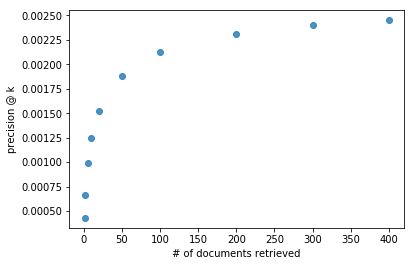

In [56]:
ax = sns.regplot(precision[:,0], precision[:,1], fit_reg=False)
ax.set(xlabel="# of documents retrieved", ylabel="precision @ k")
ax

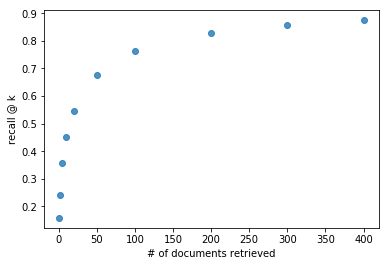

In [57]:
ax = sns.regplot(recall[:,0], recall[:,1], fit_reg=False)
ax.set(xlabel="# of documents retrieved", ylabel="recall @ k")
ax

## Evaluating results

In this section, we just look at a few of the relevant / retrieved results in order to better understand the lookup.

In [ ]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [ ]:
for claim in list(claim_to_article.keys())[:3]:
    cleaned_claim = claim.replace("/", " ")
    choices = utils.query_lucene(cleaned_claim, "10")
    retrieved = utils.process_lucene_output(choices)
    relevant = claim_to_article[claim]
    printmd("Claim: **{}**".format(claim))
    print("Retrieved {} documents.".format(len(retrieved)))
    print()
    
    print("Relevant Documents:")
    for r in relevant:
        print(r)
    print()
    
    print("Retrieved Documents:")
    for r in retrieved:
        if r in relevant:
            printmd("*{}*".format(r))
        else:
            print(r)
    print()